# MCMC for LMMs with a single vector-valued r.e. term

Creating a Stan model for linear mixed models (LMMs) with time-varying covariates in the random-effects terms requires a model matrix approach.

A simple example of a model with correlated random effects for slope and intercept is analyzed using both the [MixedModels package](https://github.com/dmbates/MixedModels.jl) and [Stan](http://mc-stan.org/) through the [Stan package](https://github.com/goedman/Stan.jl) for [Julia](http://julialang.org)

First we install the MixedModels package

In [1]:
using DataFrames,Stan,Mamba,RDatasets,MixedModels

Environment variable JULIA_SVG_BROWSER not found.


In [2]:
const slp = dataset("lme4","sleepstudy")

,Reaction,Days,Subject
1,249.56,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308
6,414.6901,5,308
7,382.2038,6,308
8,290.1486,7,308
9,430.5853,8,308
10,466.3535,9,308


Start with a model for vector-valued random effects for a single grouping factor.  In the `MixedModels` package this would be fit as

In [3]:
m1 = fit(lmm(Reaction ~ 1 + Days + (1+Days|Subject), slp))

Linear mixed model fit by maximum likelihood
Formula: Reaction ~ 1 + Days + ((1 + Days) | Subject)

 logLik: -875.969672, deviance: 1751.939344

 Variance components:
                Variance    Std.Dev.  Corr.
 Subject      565.516376   23.780588
               32.682265    5.716840   0.08
 Residual     654.940901   25.591813
 Number of obs: 180; levels of grouping factors: 18

  Fixed-effects parameters:
             Estimate Std.Error z value
(Intercept)   251.405   6.63228 37.9063
Days          10.4673   1.50224 6.96779


It is very fast to fit such a model

In [4]:
gc();@time fit(lmm(Reaction ~ 1 + Days + (1+Days|Subject), slp));

elapsed time: 0.032113435 seconds (1785416 bytes allocated)


## Creating a stan model

With some help from members of google group _stan-users_ I was able to create a stan formulation.  It is a bit tricky in that this model has random effects for time-varying covariates, `Days` in this case, and you need to form a dot product of the random-effects vector for the m'th `Subject` and a particular row of the random-effects model matrix.

In [Bates et al. (2014)](http://arxiv.org/abs/1406.5823) we describe how we use sparse matrices in the [lme4 package](https://github.com/lme4/lme4) for `R` to "expand" the evaluation of $Z\Lambda u$ across the random effects for each subject.  Matrices $Z$ and $\Lambda$ are both sparse in that formulation.

Here I create `Z` as an `array` of `row_vector`s.  `b` and `u` are arrays of column vectors.  This allows faster access to rows of `Z` and columns of `b` or `u`.


In [5]:
const VectorOne = """
data {
  int<lower=0>  N; // num observations
  int<lower=1>  K; // length of fixed-effects vector
  int<lower=1>  M; // num subjects
  int<lower=1>  J; // length of individual vector-valued random effects
  int<lower=1,upper=M> subj[N]; // subject indicator
  row_vector[K] X[N]; // model matrix for fixed-effects parameters
  row_vector[J] Z[N]; // generator model matrix for random-effects
  vector[N]     y; // response vector (reaction time)
}

parameters {
  cholesky_factor_corr[J] L; // Cholesky factor of corr in uncond r.e. dist
  vector<lower=0>[J] tau; // standard deviations of unconditional r.e. dist
  vector[K] beta;      // fixed-effects
  real<lower=0> sigma; // standard deviation of response given random effects
  vector[J] u[M];      // spherical random effects
}

transformed parameters {
  matrix[J,J] corr;
  corr <- tcrossprod(L);  // for monitoring the correlations
}

model {
  matrix[J,J] Lambda; 
  vector[J] b[M];
  tau ~ cauchy(0,2.5);
  L ~ lkj_corr_cholesky(2);
  Lambda <- diag_pre_multiply(tau,L);
  for (m in 1:M) {
    u[m] ~ normal(0,1);
    b[m] <- Lambda * u[m];
  }
  for (n in 1:N)
    y[n] ~ normal(X[n] * beta + Z[n] * b[subj[n]], sigma);
}
""";

In [6]:
const X = hcat(ones(180,1),array(slp[:Days]));
size(X)

(180,2)

In [7]:
const monitor = ["lp__","accept_stat__","corr.2.1","tau.1","tau.2","sigma","beta.1","beta.2"];

In [8]:
const sleepdata = [
  @Compat.Dict("N" => size(X,1),
    "K" => size(X,2),
    "M" => length(slp[:Subject].pool),
    "J" => size(X,2),
    "subj" => slp[:Subject].refs,
    "y" => array(slp[:Reaction]),
    "X" => X,
    "Z" => X)
];

In [9]:
stanmodel = Stanmodel(name="VectorOne", model=VectorOne, monitors=monitor, nchains=8);

In [10]:
sim1 = stan(stanmodel, sleepdata);

In [11]:
describe(sim1)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4,5,6,7,8
Samples per chain = 1000

Empirical Posterior Estimates:
9x6 Array{Any,2}:
 ""                   "Mean"    "SD"      "Naive SE"   "MCSE"         "ESS"
 "lp__"           -693.261     6.57704   0.0735335    0.170631    3447.6   
 "accept_stat__"     0.905022  0.107672  0.0012038    0.00125877  7650.7   
 "tau.1"            23.9077    6.25986   0.0699874    0.0990285   5653.92  
 "tau.2"             5.99387   1.31208   0.0146695    0.0259209   4527.48  
 "beta.1"          251.411     6.87516   0.0768667    0.110627    5558.64  
 "beta.2"           10.4714    1.59417   0.0178234    0.0298013   4784.6   
 "sigma"            26.0684    1.5948    0.0178304    0.0237383   6008.99  
 "corr.2.1"          0.122172  0.266802  0.00298294   0.00612543  3895.81  

Quantiles:
9x6 Array{Any,2}:
 ""                   "2.5%"       "25.0%"   …      "75.0%"      "97.5%"
 "lp__"           -707.33      -697.468         -688.585     -681.77   

In [12]:
p = plot(sim1,[:trace,:density]);

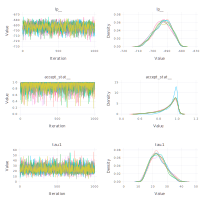

STDIN> 


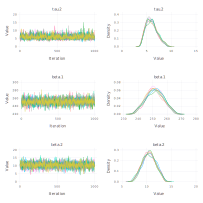

STDIN> 


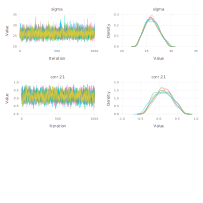

Press ENTER to draw next plot
Press ENTER to draw next plot


In [13]:
draw(p)